In [1]:
!pip install phik -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import (train_test_split, RandomizedSearchCV,
                                     GridSearchCV, cross_val_score)

from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, OrdinalEncoder,
                                   StandardScaler, MinMaxScaler)
from sklearn.model_selection import cross_validate, KFold

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (mean_absolute_error, r2_score, mean_squared_error,
                             accuracy_score, roc_auc_score, confusion_matrix,
                             recall_score, precision_score, make_scorer, roc_curve, confusion_matrix)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import (SelectKBest, mutual_info_regression,
                                       mutual_info_classif)
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from phik import report

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


RANDOM_STATE = 50525

# Анализ клиентов оператора связи 'Телеком'

### Описание

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**Информация о договорах актуальна на 1 февраля 2020 года.**

### Задача
Разработать модель машинного обучения, способную предсказывать отток клиентов телекоммуникационного оператора «ТелеДом». Это позволит компании заранее выявлять пользователей, склонных к разрыву договора, и предлагать им индивидуальные условия

**В качестве основной метрики будем использовать ROC-AUC, так как задача связана с бинарной классификацией и важна не только точность, но и способность модели различать классы.
Целевое значение ROC-AUC: не менее 0.85**

### Этапы проекта

**1. Загрузка данных**

* Загрузка всех предоставленных файлов: contract_new.csv, personal_new.csv, internet_new.csv, phone_new.csv. 
* Проверка структуры, типов данных и наличия пропущенных значений.

**2. Предварительный исследовательский анализ**

* Изучение каждого датафрейма отдельно: анализ распределения признаков, выявление аномалий и оценка значимости признаков для предсказания оттока.

**3. Предобработка данных**

* Обработка пропущенных значений, преобразование типов данных, стандартизация или категоризация признаков.
* Кодирование категориальных переменных.

**4. Объединение датафреймов**

* Объединение всех таблиц в единый датафрейм по ключу customerID.

**5. Анализ объединённого датафрейма**

* Анализ распределений признаков, корреляционный анализ, визуализация данных. 
* Генерация новых признаков при необходимости.

**6. Подготовка данных к моделированию**

* Масштабирование числовых признаков, кодирование категориальных признаков, разделение на обучающую и валидационную выборки.

**7. Обучение моделей машинного обучения**

* Построение и обучение как минимум двух моделей. Подбор гиперпараметров для улучшения качества одной из моделей.

**8. Оценка и выбор лучшей модели**

* Сравнение моделей по метрикам качества, выбор оптимальной модели и тестирование на отложенной выборке.

**9. Формирование выводов и рекомендаций**

* Подведение итогов: описание ключевых этапов работы, интерпретация результатов модели, рекомендации по применению в бизнесе для снижения оттока клиентов.

## Загрузка данных и подготовка

In [3]:
data_contract = pd.read_csv('/datasets/contract_new.csv', 
                            parse_dates=['BeginDate'],
                           converters=
                            {
                                'MonthlyCharges': float,
                                'TotalCharges': lambda x: float(x) if x.strip() else None 
                            }
                           )
data_personal = pd.read_csv('/datasets/personal_new.csv')
data_internet = pd.read_csv('/datasets/internet_new.csv')
data_phone = pd.read_csv('/datasets/phone_new.csv')

# Создаем массивы для удобной итерации по датафреймам
datasets = [data_contract, data_personal, data_internet, data_phone]
datasets_name = ['data_contract', 'data_personal', 'data_internet', 'data_phone']

In [4]:
# Функция для получения первчиной информации
def data_info(dataset):
    print("Первые строки датафрейма")
    display(dataset.head())
    print('\n\nПервичная информация')
    dataset.info()
    print('-' * 50)
    print('\n\n')

In [5]:
for data, name in zip(datasets, datasets_name):
    print(name)
    data_info(data)

data_contract
Первые строки датафрейма


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50




Первичная информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB
--------------------------------------------------



data_personal
Первые строки датафрейма


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




Первичная информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
--------------------------------------------------



data_internet
Первые строки датафрейма


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No




Первичная информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
--------------------------------------------------



data_phone
Первые строки датафрейма


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes




Первичная информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
--------------------------------------------------





<div class="alert alert-success">
<b>👍 Успех:</b> Данные загружены и просмотрены!
</div>

In [6]:
# Посмотрим на строки с пропусками в столбце TotalCharges
data_contract[data_contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Заметим, что пропуски обусловлены тем, что клиенты начали пользоваться услугами только в этом месяце


In [7]:
# Заполним такие пропуски нулями
data_contract = data_contract.fillna(0)

In [8]:
# Посмотрим на столбец BeginDAte
print(f"Пользователи начинали пользоваться услугами с {data_contract.BeginDate.min()} по {data_contract.BeginDate.max()}")

Пользователи начинали пользоваться услугами с 2013-10-01 00:00:00 по 2020-02-01 00:00:00


### Вывод

Заметим, что в базе данных phone_new.csv и internet_new.csv меньше данных, чем в первых двух датафреймах, это скорее всего произошло из-за того, что  не все люди пользуются услугами

В данных были, пропуски т.к клиенты еще не успели попользоваться услугами

Столбцы приведены к нужному типу данных

## Анализ исходных датафреймов

In [9]:
# Проверим данные на дубликаты
for data, name in zip(datasets, datasets_name):
    print(f"Дубликатов в {name} оббнаружено {data.duplicated().sum()}")

Дубликатов в data_contract оббнаружено 0
Дубликатов в data_personal оббнаружено 0
Дубликатов в data_internet оббнаружено 0
Дубликатов в data_phone оббнаружено 0


In [10]:
# Проверим данные на уникальные значения категориальных признаков
for data, name in zip(datasets, datasets_name):
    print(name)
    print()
    string_columns = data.iloc[:, 1:].select_dtypes(include='object')
    for col in string_columns:
        print(col)
        print(data[col].unique())
        print()
    print('-' * 50)
    print('\n')

data_contract

EndDate
['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' '2014-12-01'
 '2014-11-01']

Type
['Month-to-month' 'One year' 'Two year']

PaperlessBilling
['Yes' 'No']

PaymentMethod
['Elec

Заметим, что в датафрейме data_contract в столбце EndDate не только даты, но и значение `'No'`

Из этого столбца выделим таргет, если есть дата окончания, то значит клиент прекратил пользование услугами и ушел, а если в этом признаке указано 'no', то клиент все еще пользуется услугми

In [11]:
data_contract['quit'] = data_contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,quit
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0


### Вывод

Дубликатов не обнаружено

Выделен таргет `'quit'`

## Обьединение таблиц

Т.к нам важно чтобы была наиболее полная информация о клиентах, то будеи присоединять к таблице data_contract, т.к иначе мы можем получить пользователей, догоовора которых не учитваются, что нам не подходит

In [12]:
# Объединение с personal_new.csv
data = data_contract.merge(data_personal, on='customerID', how='left')

# Объединение с internet_new.csv
data = data.merge(data_internet, on='customerID', how='left')

# Объединение с phone_new.csv
data = data.merge(data_phone, on='customerID', how='left')

data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,quit,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


## Исследовательский анализ и предобработка данных объединённого датафрейма


### Предобработка

In [13]:
# Посмотрим на образовавшиеся пропуски
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
quit                   0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [14]:
# Посмотрим на пропуски из таблицы data_internet
data[data['InternetService'].isna()].isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
quit                   0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines          0
dtype: int64

Получаем, что есть клиенты, которые пользуются только телефоном и не пользуются интернетом

In [15]:
# Заполним такие пропуски заглушкой 'no_use'
cols_with_missing = [
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

data[cols_with_missing] = data[cols_with_missing].fillna('no_use')

In [16]:
# Аналогично посмотрим на пропуски из таблицы data_phone
data[data['MultipleLines'].isna()].isna().sum()

customerID            0
BeginDate             0
EndDate               0
Type                  0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
quit                  0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
MultipleLines       682
dtype: int64

Получаем, что есть клиенты, которые пользуются только интернетом и не пользуются телефоном

In [17]:
# Заполним такие пропуски заглушкой 'no_use'
data['MultipleLines'] = data['MultipleLines'].fillna('no_use')

In [18]:
# Опять посмотрим на пропуски
data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
quit                0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [19]:
# Проверим, плоявились ли дубликаты
data.duplicated().sum()

0

### Исследовательский анализ

In [20]:
# Создадим функцию для визуализации распределений
def visualize_distributions(df):
    # Столбцы по типам
    string_columns = df.select_dtypes(include='object')
    num_columns = df.select_dtypes(include=['int64', 'float64'])
    
    # Дискретные переменные: целочисленные с небольшим количеством уникальных значений
    discr_columns = [col for col in num_columns.columns if df[col].nunique() <= 10]
    
    num_columns = num_columns.drop(columns=discr_columns)

    print("Числовые непрерывные признаки:")
    for col in num_columns:
        print(f"\nСтатистика для {col}:")
        print(df[col].describe())
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        df[col].plot.box(ax=axes[0])
        axes[0].set_title(f'{col}')
        axes[0].grid(True)
        df[col].plot.hist(bins=20, ax=axes[1])
        axes[1].set_title(f'{col}')
        axes[1].grid(True)
        plt.tight_layout()
        plt.show()

    print("Дискретные числовые признаки:")
    for col in discr_columns:
        print(f"\nЧастотное распределение для {col}:")
        print(df[col].value_counts())
        print("\nПроцентное соотношение:")
        print(df[col].value_counts(normalize=True) * 100)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        df[col].value_counts().plot.bar(ax=axes[0])
        axes[0].set_title(f'{col}')
        axes[0].grid(True)
        df[col].value_counts().plot.pie(
            autopct='%1.1f%%',
            startangle=90,
            wedgeprops={'edgecolor': 'black', 'linewidth': 1},
            ax=axes[1]
        )
        axes[1].set_title(f'{col}')
        axes[1].set_ylabel('')
        plt.tight_layout()
        plt.show()

    print("Категориальные признаки:")
    for col in string_columns.columns:
        print(f"\nЧастотное распределение для {col}:")
        print(df[col].value_counts())
        print("\nПроцентное соотношение:")
        print(df[col].value_counts(normalize=True) * 100)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        df[col].value_counts().plot.bar(ax=axes[0])
        axes[0].set_title(f'{col}')
        axes[0].grid(True)
        df[col].value_counts().plot.pie(
            autopct='%1.1f%%',
            startangle=90,
            wedgeprops={'edgecolor': 'black', 'linewidth': 1},
            ax=axes[1]
        )
        axes[1].set_title(f'{col}')
        axes[1].set_ylabel('')
        plt.tight_layout()
        plt.show()

In [21]:
# Уберем столбцы, которые не нужны для анализа
data_analys = data.drop(columns = ['customerID','quit','BeginDate','EndDate'])

Числовые непрерывные признаки:

Статистика для MonthlyCharges:
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64


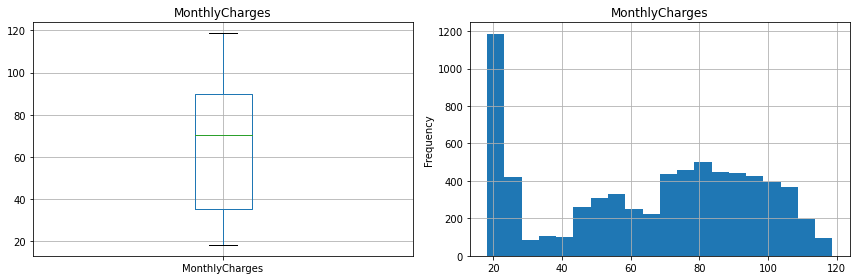


Статистика для TotalCharges:
count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64


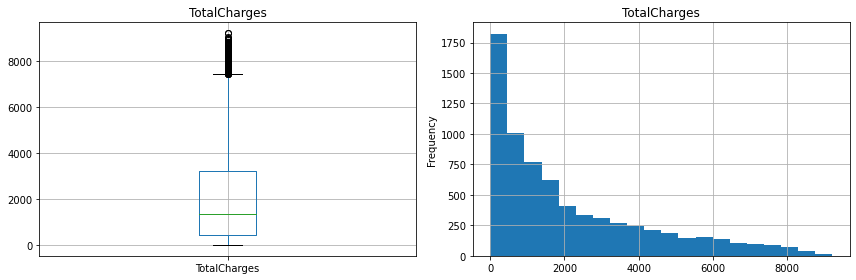

Дискретные числовые признаки:

Частотное распределение для SeniorCitizen:
0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Процентное соотношение:
0    83.785319
1    16.214681
Name: SeniorCitizen, dtype: float64


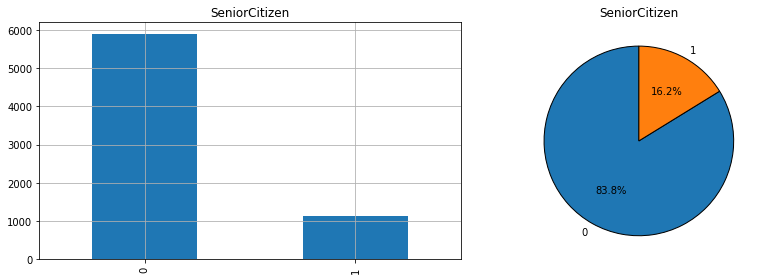

Категориальные признаки:

Частотное распределение для Type:
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Процентное соотношение:
Month-to-month    55.019168
Two year          24.066449
One year          20.914383
Name: Type, dtype: float64


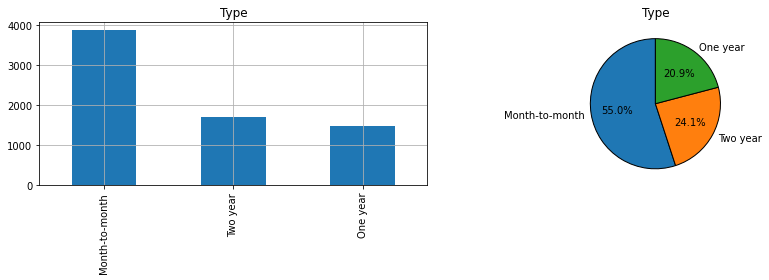


Частотное распределение для PaperlessBilling:
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Процентное соотношение:
Yes    59.221922
No     40.778078
Name: PaperlessBilling, dtype: float64


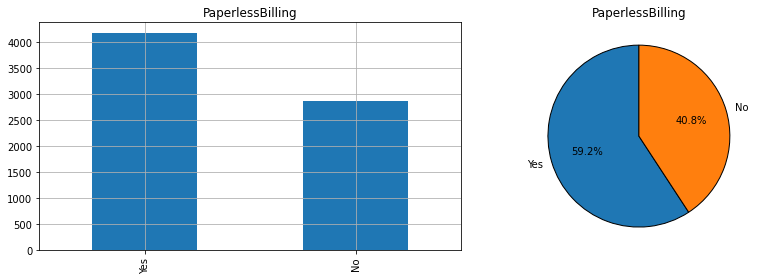


Частотное распределение для PaymentMethod:
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Процентное соотношение:
Electronic check             33.579441
Mailed check                 22.887974
Bank transfer (automatic)    21.922476
Credit card (automatic)      21.610109
Name: PaymentMethod, dtype: float64


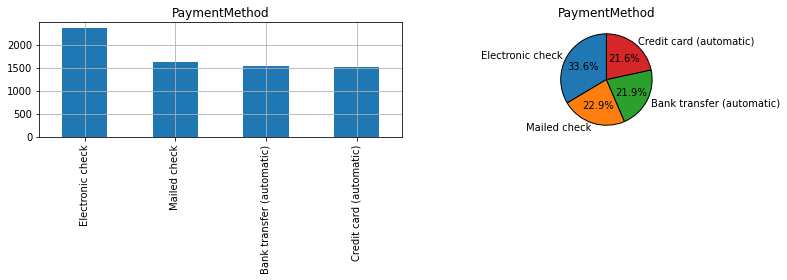


Частотное распределение для gender:
Male      3555
Female    3488
Name: gender, dtype: int64

Процентное соотношение:
Male      50.47565
Female    49.52435
Name: gender, dtype: float64


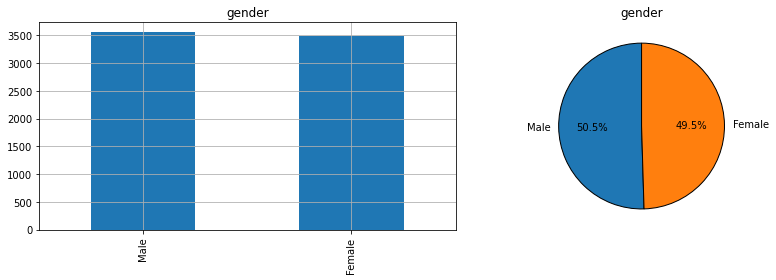


Частотное распределение для Partner:
No     3641
Yes    3402
Name: Partner, dtype: int64

Процентное соотношение:
No     51.69672
Yes    48.30328
Name: Partner, dtype: float64


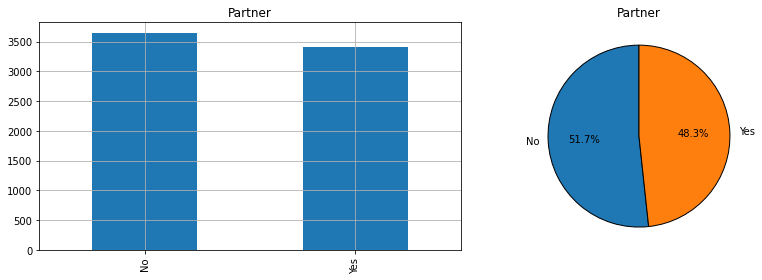


Частотное распределение для Dependents:
No     4933
Yes    2110
Name: Dependents, dtype: int64

Процентное соотношение:
No     70.041176
Yes    29.958824
Name: Dependents, dtype: float64


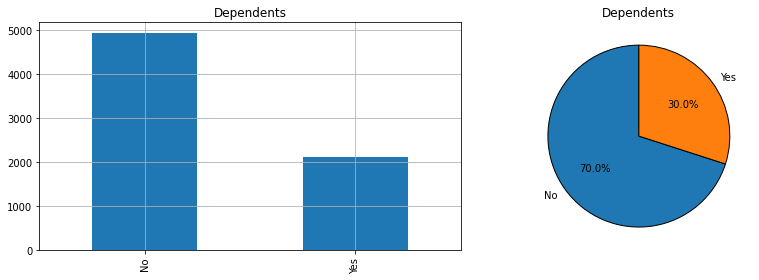


Частотное распределение для InternetService:
Fiber optic    3096
DSL            2421
no_use         1526
Name: InternetService, dtype: int64

Процентное соотношение:
Fiber optic    43.958540
DSL            34.374556
no_use         21.666903
Name: InternetService, dtype: float64


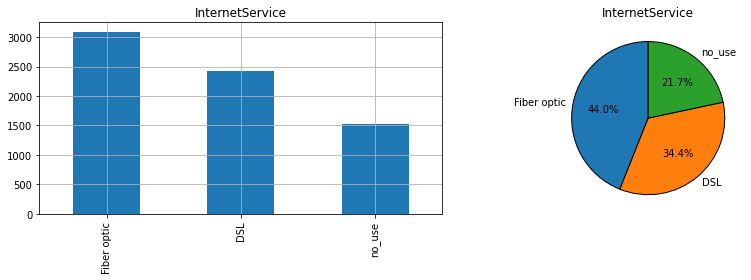


Частотное распределение для OnlineSecurity:
No        3498
Yes       2019
no_use    1526
Name: OnlineSecurity, dtype: int64

Процентное соотношение:
No        49.666335
Yes       28.666761
no_use    21.666903
Name: OnlineSecurity, dtype: float64


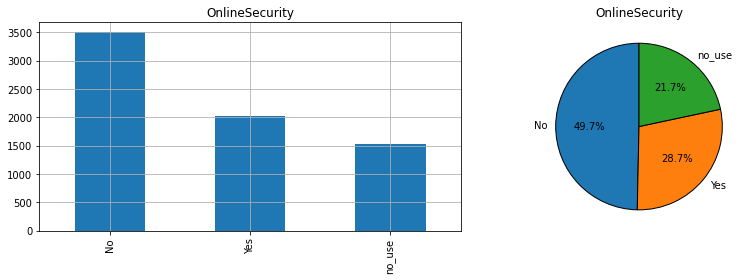


Частотное распределение для OnlineBackup:
No        3088
Yes       2429
no_use    1526
Name: OnlineBackup, dtype: int64

Процентное соотношение:
No        43.844952
Yes       34.488144
no_use    21.666903
Name: OnlineBackup, dtype: float64


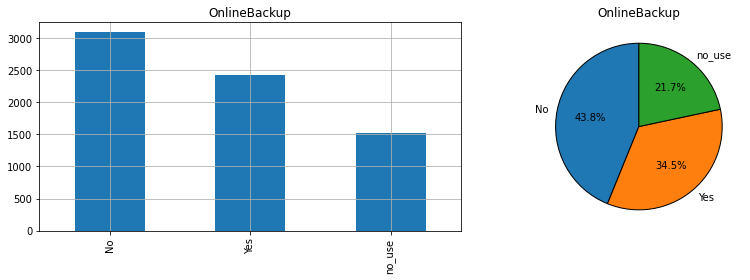


Частотное распределение для DeviceProtection:
No        3095
Yes       2422
no_use    1526
Name: DeviceProtection, dtype: int64

Процентное соотношение:
No        43.944342
Yes       34.388755
no_use    21.666903
Name: DeviceProtection, dtype: float64


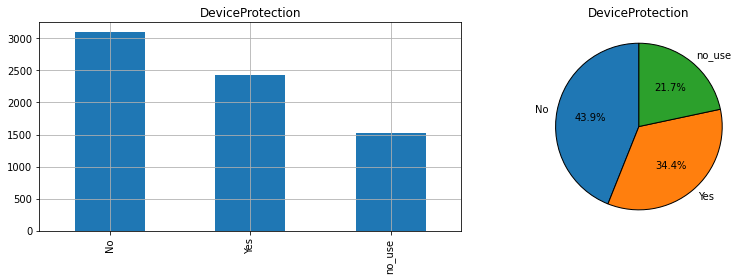


Частотное распределение для TechSupport:
No        3473
Yes       2044
no_use    1526
Name: TechSupport, dtype: int64

Процентное соотношение:
No        49.311373
Yes       29.021724
no_use    21.666903
Name: TechSupport, dtype: float64


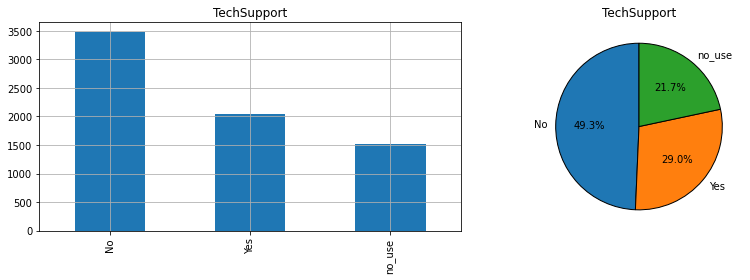


Частотное распределение для StreamingTV:
No        2810
Yes       2707
no_use    1526
Name: StreamingTV, dtype: int64

Процентное соотношение:
No        39.897771
Yes       38.435326
no_use    21.666903
Name: StreamingTV, dtype: float64


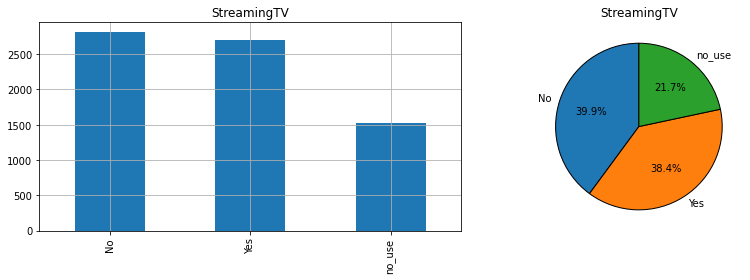


Частотное распределение для StreamingMovies:
No        2785
Yes       2732
no_use    1526
Name: StreamingMovies, dtype: int64

Процентное соотношение:
No        39.542808
Yes       38.790288
no_use    21.666903
Name: StreamingMovies, dtype: float64


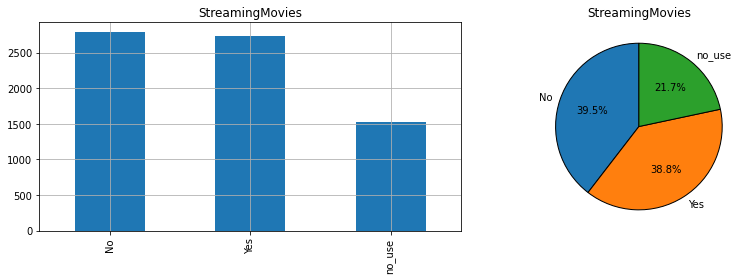


Частотное распределение для MultipleLines:
No        3390
Yes       2971
no_use     682
Name: MultipleLines, dtype: int64

Процентное соотношение:
No        48.132898
Yes       42.183729
no_use     9.683374
Name: MultipleLines, dtype: float64


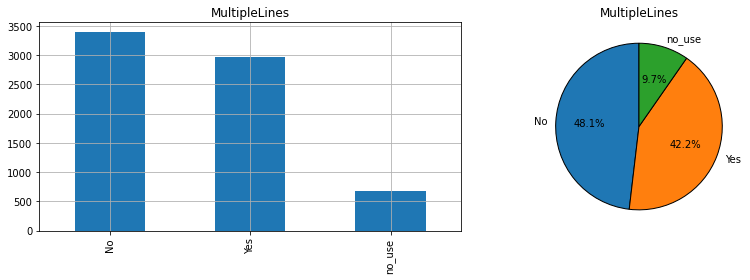

In [22]:
visualize_distributions(data_analys)

Теперь посмотрим на визуализации в зависимости от таргета

In [23]:
string_columns = [col for col in data_analys.columns if data_analys[col].nunique() <= 10]
num_columns = data_analys.select_dtypes(include=['int64', 'float64'])

discr_columns = [col for col in num_columns.columns if data_analys[col].nunique() <= 10]
num_columns = num_columns.drop(columns=discr_columns)

In [24]:
# Разделяем клиентов
quit_group = data[data['quit'] == 1]
stay_group = data[data['quit'] == 0]

In [25]:
len(string_columns)

15

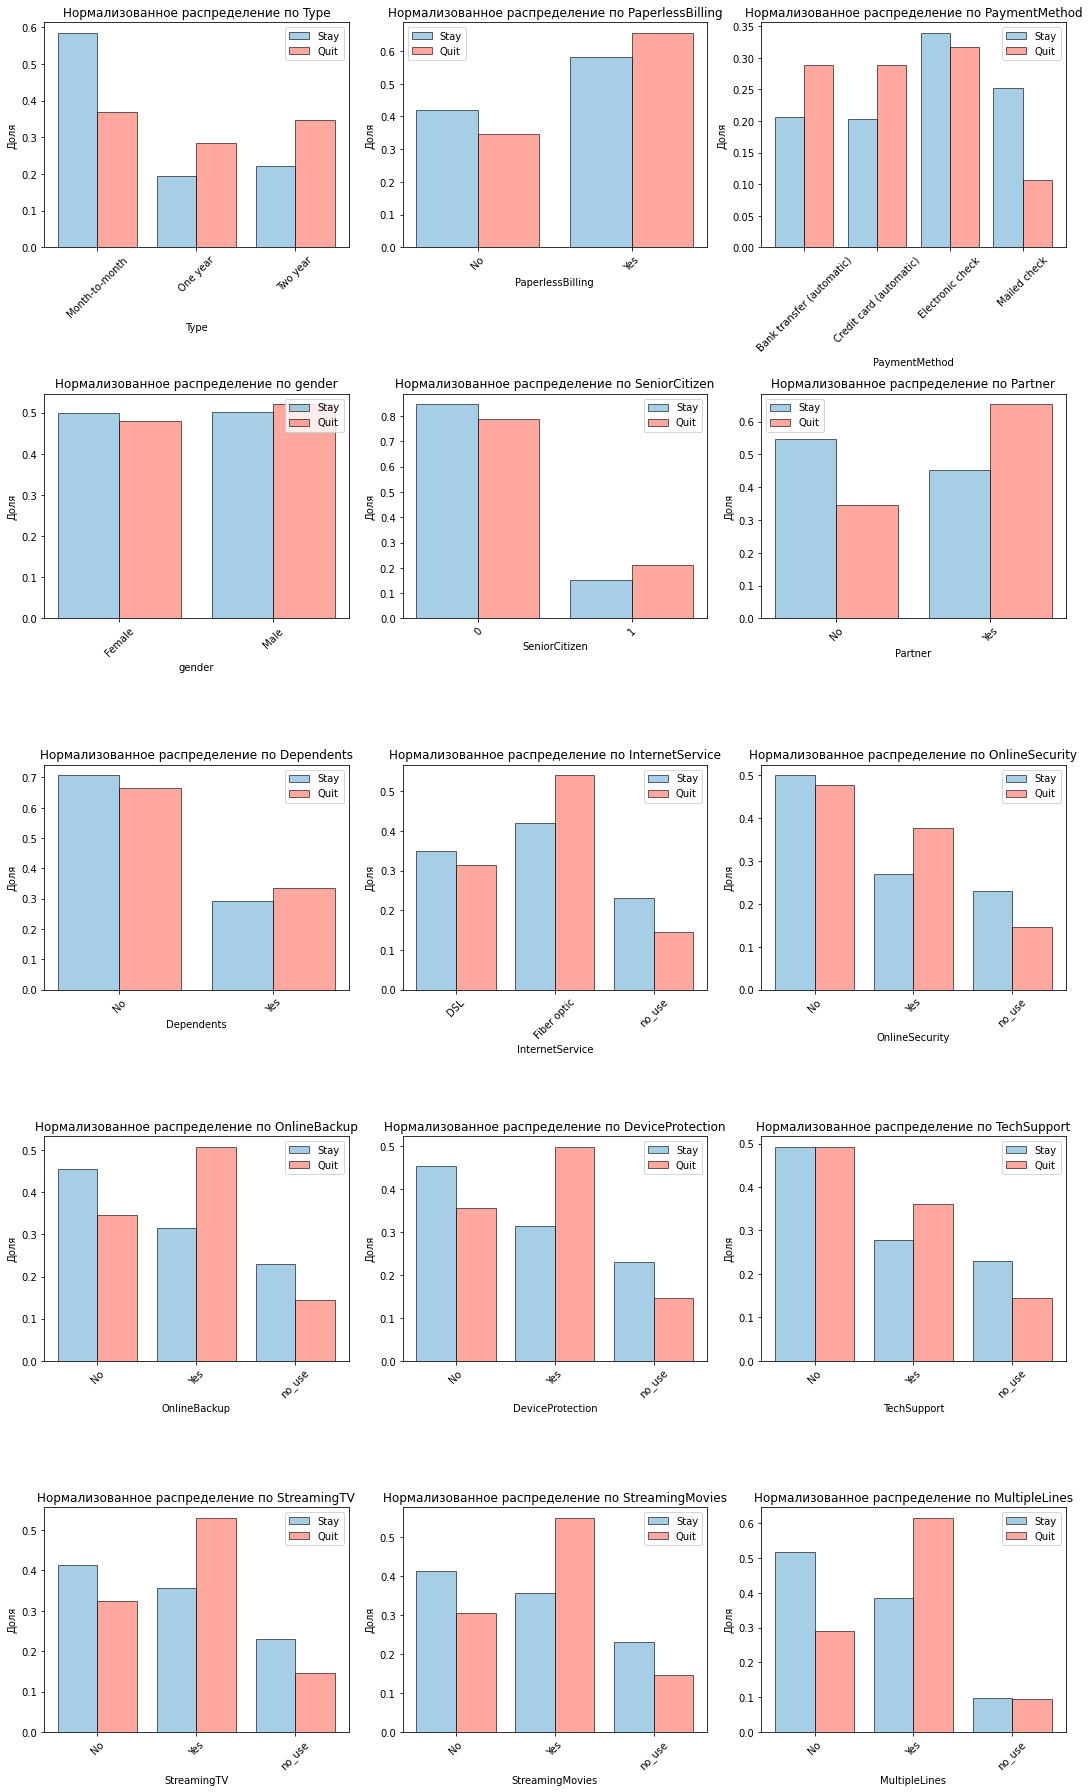

In [26]:
rows = 5  
cols = 3  

num_plots = len(string_columns)
fig, axes = plt.subplots(rows, cols, figsize=(15, 25))
axes = axes.flatten()

for i, col in enumerate(string_columns):

    quit_counts = quit_group[col].value_counts(normalize=True).sort_index()
    stay_counts = stay_group[col].value_counts(normalize=True).sort_index()

    categories = quit_counts.index.union(stay_counts.index)
    quit_counts = quit_counts.reindex(categories, fill_value=0)  
    stay_counts = stay_counts.reindex(categories, fill_value=0)  

    width = 0.4  
    x = range(len(categories)) 

    ax = axes[i]

    ax.bar([i - width/2 for i in x], stay_counts.values, width=width, label='Stay', alpha=0.6, color='#6BAED6', edgecolor='black')
    ax.bar([i + width/2 for i in x], quit_counts.values, width=width, label='Quit', alpha=0.6, color='#FF6F61', edgecolor='black')

    ax.set_title(f'Нормализованное распределение по {col}')
    ax.set_ylabel('Доля')
    ax.set_xlabel(col)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()

#### Промежуточные выводы 

* Заметим, что доля тех, кто прекратил пользоваться услугами чаще заключали контракты на один или два года, возможно им предлагали выгодые условия или тарифы, после чего они прекращали пользоваться услугами


* Клиенты, у которых есть партнер чаще прекращали пользоваться услугами, вероятно скорости интернета было недостаточно для нескольких людей


* Клиенты, которые пользовались интернетом и выбирали fiber optic чаще прекращали пользоваться услугами, вероятно возникали какие-то проблемы с установкой или эксплуатацией


* Доля клиентов, которые пользовались интернетом и пользовались другими услугами и покидали компанию выше чем доля тех, кто оставался. Это может быть связано с низким качеством этих услуг, что вызывает неудовлетворенность клиентов. Также конкуренция с более выгодными предложениями может быть фактором ухода. Кроме того, изменения в потребностях клиентов, такие как уменьшение необходимости в нескольких услугах, могут привести к отказу от них


* Чаще уходили те, кто пользовался автоматической системой оплаты


* Таргет не зависит от пола или от возраста клиентов

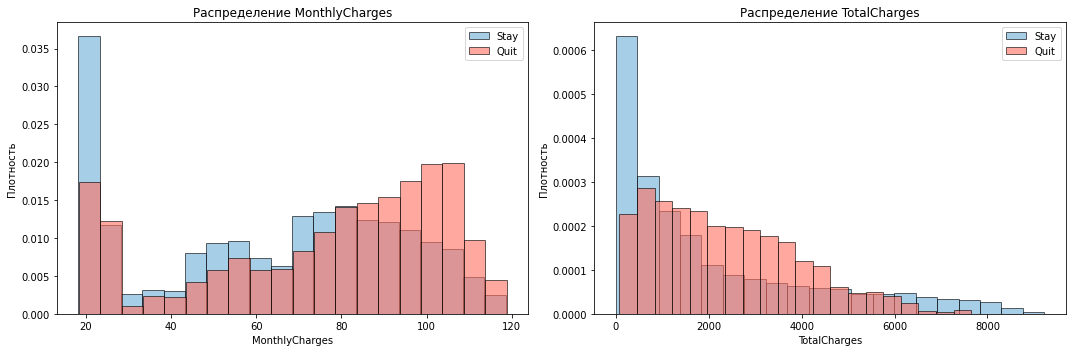

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

for idx, col in enumerate(num_columns):
    ax = axes[idx % 2]
    ax.hist(stay_group[col], bins=20, alpha=0.6, label='Stay', color='#6BAED6', edgecolor='black', density=True)
    ax.hist(quit_group[col], bins=20, alpha=0.6, label='Quit', color='#FF6F61', edgecolor='black', density=True)
    ax.set_title(f'Распределение {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Плотность')
    ax.legend()

plt.tight_layout()
plt.show()

#### Промежуточные выводы 

* Заметим, что то, кто прекратил пользоваться услугами чаще платили в месяц больше тех, кто не прекратил пользоваться услугами


0    5942
1    1101
Name: quit, dtype: int64


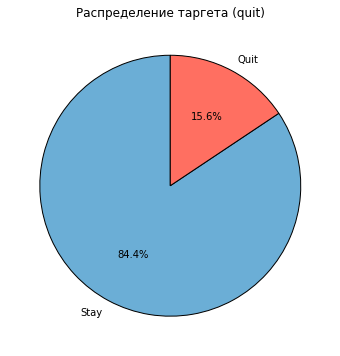

In [28]:
# Посмотрим на распределение таргета
target_counts = data['quit'].value_counts()
print(target_counts)
plt.figure(figsize=(6, 6))
plt.pie(
    target_counts,
    labels=target_counts.index.map({0: 'Stay', 1: 'Quit'}),
    autopct='%1.1f%%',
    colors=['#6BAED6', '#FF6F61'],
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Распределение таргета (quit)')
plt.show()

Закодируем все категориальные признаки при помощи LabelEncoder и попробуем построить pairplot 

In [29]:
# data_encoded = data.copy()

# cat_cols = data_encoded.select_dtypes(include='object').columns.drop('customerID')

# le = LabelEncoder()
# for col in cat_cols:
#     data_encoded[col] = le.fit_transform(data_encoded[col].astype(str))

# sns.pairplot(data_encoded, hue='quit', palette={0: '#6BAED6', 1: '#FF6F61'}, corner=True, height=2.5)
# plt.show()

Ничего что, могло бы быть полезным я не заметил

### Вывод

1. Предобработка

    * Были заполнены пропуски зашлушками 'no_use', для тех кто не пользовался мобильной связью или интернетом


2. Анализ

    * Заметим, что доля тех, кто прекратил пользоваться услугами чаще заключали контракты на один или два года, возможно им предлагали выгодые условия или тарифы, после чего они прекращали пользоваться услугами

    * Клиенты, у которых есть партнер чаще прекращали пользоваться услугами, вероятно скорости интернета было недостаточно для нескольких людей

    * Клиенты, которые пользовались интернетом и выбирали fiber optic чаще прекращали пользоваться услугами, вероятно возникали какие-то проблемы с установкой или эксплуатацией

    * Доля клиентов, которые пользовались интернетом и пользовались другими услугами и покидали компанию выше чем доля тех, кто оставался. Это может быть связано с низким качеством этих услуг, что вызывает неудовлетворенность клиентов. Также конкуренция с более выгодными предложениями может быть фактором ухода. Кроме того, изменения в потребностях клиентов, такие как уменьшение необходимости в нескольких услугах, могут привести к отказу от них

    * Таргет не зависит от пола или от возраста клиентов
    
    * Заметим, что то, кто прекратил пользоваться услугами чаще платили в месяц больше тех, кто не прекратил пользоваться услугами
    
    
3. Таргет
    * Данные несбалансированы относительно тарегта, возможно будем использовться оверсэмплинг или андерсемплинг

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## Корреляционный анализ

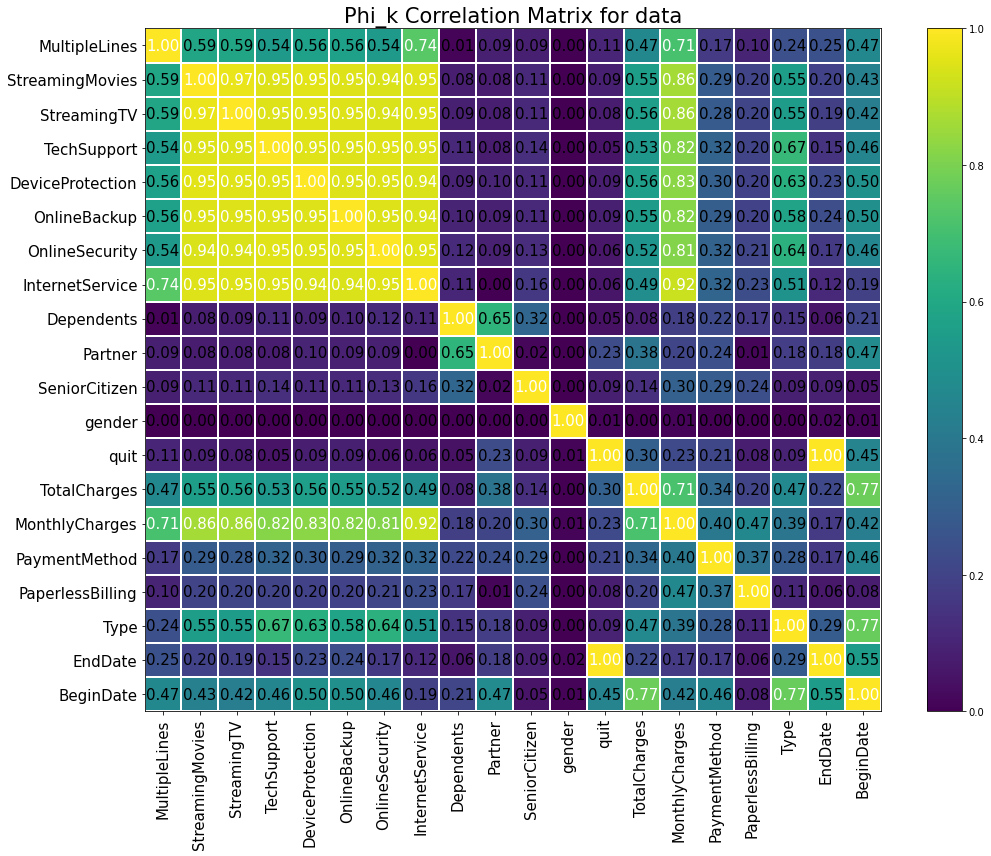

In [30]:
interval_cols = ['MonthlyCharges', 'TotalCharges']
phik_matrix = data.drop(columns = ['customerID']).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='viridis',
    title='Phi_k Correlation Matrix for data',
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Заметим мультиколлинеарность между признаками, связанными с дополнительными услугами, а так же утечку данных - признак EndDate

## Создание новый признаков

1. Все признаки, связанные с дополнительными услугами коррелируют между собой, возможно потому что все дополнительные услуги поставлялись пакетом все вместе. Заменим все эти признаки на один - additional_service, который будет показывать количество дополнительных услуг

2. Т.к из признака EndDate мы создали таргет, а в реальных условиях у нас не будет этого признака, то создадим новый признак - service_day, который будет показывать сколько дней клиент пользуется сервисами

3. Удалим признак BeginDate 

In [31]:
additional_cols = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
data['additional_service'] = data[additional_cols].apply(lambda row: (row == 'Yes').sum(), axis=1)
data = data.drop(columns=additional_cols)

In [32]:
data['EndDate'] = pd.to_datetime(data['EndDate'], errors='coerce')
current_date = pd.to_datetime('2020-02-01')

data['service_day'] = (data['EndDate'].fillna(current_date) - data['BeginDate']).dt.days
data.drop(columns='EndDate', inplace=True)

In [33]:
data = data.drop(columns=['BeginDate'])

In [34]:
data.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,quit,gender,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,additional_service,service_day
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,0,Yes,No,DSL,no_use,1,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,Male,0,No,No,DSL,No,2,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,0,No,No,DSL,No,2,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,0,No,No,DSL,no_use,3,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,0,No,No,Fiber optic,No,0,153


Теперь посмотрим на распределения новых признаков в зависимости от таргета

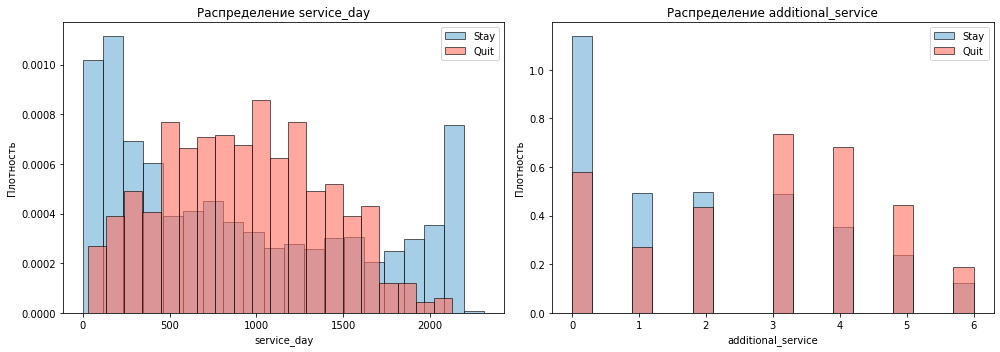

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].hist(data[data['quit'] == 0]['service_day'], bins=20, alpha=0.6, label='Stay', color='#6BAED6', edgecolor='black', density=True)
axes[0].hist(data[data['quit'] == 1]['service_day'], bins=20, alpha=0.6, label='Quit', color='#FF6F61', edgecolor='black', density=True)
axes[0].set_title('Распределение service_day')
axes[0].set_xlabel('service_day')
axes[0].set_ylabel('Плотность')
axes[0].legend()

axes[1].hist(data[data['quit'] == 0]['additional_service'], bins=20, alpha=0.6, label='Stay', color='#6BAED6', edgecolor='black', density=True)
axes[1].hist(data[data['quit'] == 1]['additional_service'], bins=20, alpha=0.6, label='Quit', color='#FF6F61', edgecolor='black', density=True)
axes[1].set_title('Распределение additional_service')
axes[1].set_xlabel('additional_service')
axes[1].set_ylabel('Плотность')
axes[1].legend()

plt.tight_layout()
plt.show()

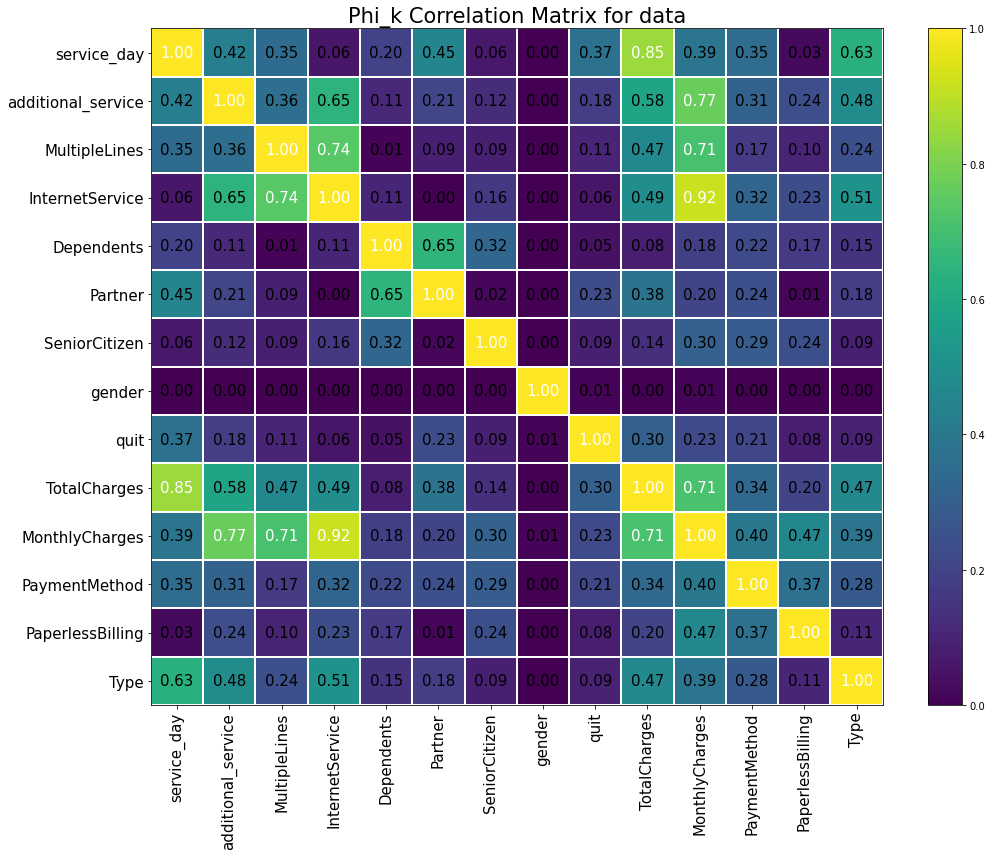

In [36]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'service_day', 'additional_servise']
phik_matrix = data.drop(columns = ['customerID']).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='viridis',
    title='Phi_k Correlation Matrix for data',
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Заметим. что новые признаки сильно коррелирую с таргетом, особенно service_day

## Подготовка данных к моделированию

Разделим данные на тренировочную и валидационную

In [37]:
X = data.drop(columns=['quit', 'customerID'])
y = data['quit']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=RANDOM_STATE, 
    stratify=y
)

Создадим пайплайн для подготовки данных

In [38]:
ohe_columns =  X.select_dtypes(include=['object']).columns.tolist()
num_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [39]:
print(ohe_columns)
print()
print(num_columns)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'MultipleLines']

['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'additional_service', 'service_day']


In [40]:
ohe_columns.append('SeniorCitizen')
num_columns.remove('SeniorCitizen')

In [41]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка num_columns: заполнение пропусков и скалирование
# SimpleImputer + Scaler
num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
     ('scaler', StandardScaler())
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [42]:
# создаём итоговый пайплайн для логистической регрессии
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

In [43]:
#--------

## Обучение моделей

In [44]:
param_grid = {
    'model': [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        RandomForestClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        LGBMClassifier(random_state=RANDOM_STATE),
        CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)
    ]
}

In [45]:
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

In [46]:
%%time
grid = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring = roc_auc_scorer,
    n_jobs=-1
)
grid.fit(X_train, y_train)

CPU times: user 25 s, sys: 3.16 s, total: 28.1 s
Wall time: 33.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                 

In [47]:
print('Лучшая модель:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели с кросс-валидацией:', grid.best_score_)

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod', 'gender',
                                                   'Partner', 'Dependents',
                                                   'InternetService',
                                                   'MultipleLines',
                                                   'SeniorCitizen']),
                      

**ЛУчшей моделью оказался CatBoost**, попробуем перебрать гиперпараметры для модели и провести отбор признаков

### Важность признаков

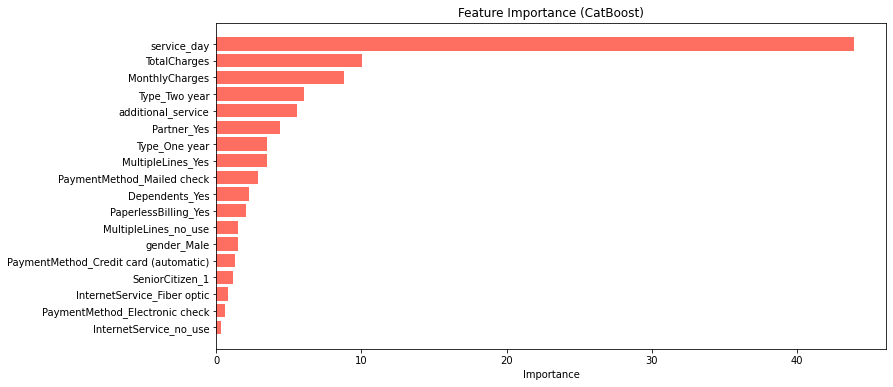

In [48]:
# Посмотрим на самые важные признаки
model = grid.best_estimator_.named_steps['model']

# Получаем важность признаков
feature_importances = model.get_feature_importance()

column_transformer = grid.best_estimator_.named_steps['preprocessor']

ohe_columns = column_transformer.transformers_[0][1].named_steps['ohe'].get_feature_names(input_features=ohe_columns)

final_columns = list(ohe_columns) + num_columns

feature_importance_df = pd.DataFrame({
    'Feature': final_columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#FF6F61')
plt.xlabel('Importance')
plt.title('Feature Importance (CatBoost)')
plt.gca().invert_yaxis()
plt.show()

Как мы и выяснили на этапе анализа данных самыми важными признаками оказались:
* service_day
* TotalCharges
* Type
* additional_service
* Partner

### Отбор признаков

т.к некоторые признаки вносят очень маленький вклад в работу модели, то попробуем провести отбор признаков

In [ ]:
# Перебираем разное k
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for i in range(10, 16):
    feature_selection = SelectKBest(mutual_info_classif, k=i)

    pipe_final_features = Pipeline([
        ('preprocessor', data_preprocessor),
        ('feature_selection', feature_selection),
        ('model', CatBoostClassifier(verbose=0, random_state=RANDOM_STATE))
    ])
    cv_scores = cross_val_score(pipe_final_features, X_train, y_train,
                                cv=cv, scoring='roc_auc', n_jobs=-1)
    
    print(i)
    print(f'Среднее значение ROC AUC: {cv_scores.mean()}')
    print()

10
Среднее значение ROC AUC: 0.8834735072893212

11
Среднее значение ROC AUC: 0.8778400560709432

12
Среднее значение ROC AUC: 0.8769432038763183

13
Среднее значение ROC AUC: 0.8721452640736486

14
Среднее значение ROC AUC: 0.8794709335320678



Лучшее значение при k = 10

### Подбор гиперпараметров

In [50]:
feature_selection = SelectKBest(mutual_info_classif, k=10)

pipe_final_params = Pipeline([
    ('preprocessor', data_preprocessor),
    ('feature_selection', feature_selection),
    ('model', CatBoostClassifier(verbose=0, random_state=RANDOM_STATE))
])

In [51]:
param_dist = {
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.1, 0.2, 0.3] 
}

In [52]:
%%time
random_search = RandomizedSearchCV(
    pipe_final_params,
    param_distributions=param_dist,  
    cv=5,       
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 1min 56s, sys: 2.35 s, total: 1min 58s
Wall time: 2min 34s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['Type',
                                                                                'PaperlessBilling',
                                                                

In [53]:
print("Лучшие параметры:", random_search.best_params_)
print(f'ROC AUC на кросс валидации: {random_search.best_score_}')

Лучшие параметры: {'model__learning_rate': 0.1, 'model__depth': 4}
ROC AUC на кросс валидации: 0.9080981389539826


### Прогноз

In [54]:
model = random_search.best_estimator_
y_proba = model.predict_proba(X_test)[:, 1]
print(f"ROC_AUC на валидационной выборке: {roc_auc_score(y_test, y_proba)}")

ROC_AUC на валидационной выборке: 0.9343863942248869


### Изучение результатов модели

In [55]:
# посчитаем accuracy
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9364


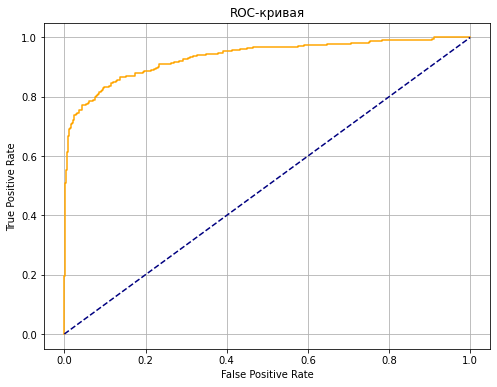

In [56]:
# Посмотрим на ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid(True)
plt.show()

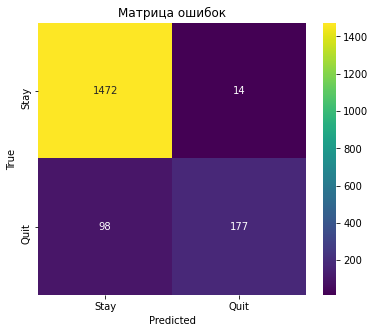

In [57]:
# Посмотрим на матрицу ошибок
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Stay', 'Quit'], yticklabels=['Stay', 'Quit'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Матрица ошибок')
plt.show()

**ROC curve**

Кривая на графике идёт близко к верхнему левому углу, что близко к идеальной модели и говорит о том, что модель хорошо определяет вероятность принадлежнсоти к классам

**Матрица ошибок**

Матрица ошибок показывает, что модель правильно предсказала большую часть клиентов, как ушедших, так и оставшихся. Ложно отрицательных — когда ушедшие клиенты были классифицированы как оставшиеся — немного больше, чем ложно положительных. Это может быть важным, так как такие ошибки могут привести к потере клиентов, которых можно было бы удержать 

## Выводы

**Предобработка данных:**
- Заполнены пропуски в данных `'no_use'` 
- Созданы новые информативные признаки: `service_day` (длительность обслуживания) и `additional_service` (кол-во дополнительных услуг)
- Удалены признаки `EndDate` и `BeginDate`

**Исследовательский анализ:**
- Пол и возраст не влияют на отток
- Клиенты с длинными контрактами чаще прекращают пользоваться услугами
- Наличие партнёра увеличивает вероятность оттока — возможно, из-за неудобства совместного пользования
- Пользователи с `Fiber Optic` чаще уходят, вероятно, из-за проблем с качеством.
- Уходят чаще те, кто использует больше дополнительных услуг — возможна неудовлетворенность качеством или наличие более выгодных альтернатив
- Автоматическая оплата и высокая сумма ежемесячных платежей также связаны с оттоком
- Новый признак `service_day` оказался одним из сильнейших важнейших

**Модель и качество:**
- Использована модель CatBoost с настройкой гиперпараметров (`learning_rate=0.2`, `depth=4`).
- ROC AUC на кросс-валидации: **0.91**, на тестовой выборке: **0.93** — высокая точность предсказаний.

## Рекомендации

### 1. Удержание лояльных клиентов
- Использовать признак `service_day` для определения продолжительности пользования услугами
- Чем **дольше клиент обслуживается**, тем **больше он должен получать выгодных предложений**: скидки, расширенные пакеты, приоритетную поддержку
- Разработать систему **программ лояльности**

### 2. Работа с клиентами, использующими несколько услуг
- Выделять клиентов с большим числом подключённых дополнительных сервисов и предлагать им расширенные пакеты или бонусные услуги
- Прозрачно сообщать о стоимости и выгодах от использования полного пакета
- Улучшить качество услуг

### 3. Оптимизация системы оплаты
- Внимательно отслеживать отток среди пользователей автоматической оплаты
- Обеспечить удобные способы управления оплатой: напоминания, отчёты о списаниях, гибкая настройка даты списания

### 4. Персонализированные предложения
- Настроить систему уведомлений и маркетинговых предложений в зависимости от профиля клиента: срок пользования, тип подключения, сумма ежемесячной оплат
- Применять прогнозную модель оттока, чтобы **заранее** предлагать персональные акции клиентам с высоким риском ухода
